In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import numpy as np
from random import randint

plt.style.use(["Solarize_Light2"])
plt.rcParams["axes.edgecolor"] = "#66818c"
plt.rcParams["axes.facecolor"] = "#263238"
plt.rcParams["figure.facecolor"] = "#263238"
plt.rcParams["grid.color"] = "#3f575b"
plt.rcParams["xtick.color"] = "#bfd5dd"
plt.rcParams["ytick.color"] = "#bfd5dd"
plt.rcParams["text.color"] = "#bfd5dd"
plt.rcParams["axes.labelcolor"] = "#bfd5dd"

engine = create_engine("postgresql+psycopg2://{}:{}@{}:{}/{}".format())

In [3]:
query = """ SELECT area,
                   area_kitchen,
                   area_living,
                   price
            FROM flat
        """
df = pd.read_sql(query, engine)
df.loc[:, "ppm"] = df.price / df.area
df = df[df.area_kitchen < 4e+1]
df.drop("price", axis=True, inplace=True)

In [8]:
df_ = df[~df.area_living.isnull()]
X = df_.drop("area_kitchen", axis=True)
y = df_.ppm
X = ((X-X.mean())/X.std()).values
y = ((y-y.mean())/y.std()).values
XX = X.T.dot(X)
w = np.linalg.inv(np.linalg.norm(XX) + XX).dot(X.T).dot(y)
w

array([-0.14705724, -0.25279249,  0.63507989])

In [5]:
for i in df.loc[df.area_kitchen.isnull() & ~df.area_living.isnull()].index:
    X_ = df.loc[i, ["area", "area_living", "ppm"]]
    X_ = ((X_-X_.mean())/X_.std()).values
    a = X_.dot(w)
    if a > df.loc[:, "area_kitchen"].mean():
        df.loc[i, "area_kitchen"] = a - df.loc[:, "area_kitchen"].std()
    else:
        df.loc[i, "area_kitchen"] = a + df.loc[:, "area_kitchen"].std()

In [6]:
df_ = df[~df.area_kitchen.isnull()]
X = df_.drop("area_living", axis=True)
y = df_.ppm
X = ((X-X.mean())/X.std()).values
y = ((y-y.mean())/y.std()).values
XX = X.T.dot(X)
w = np.linalg.inv(np.linalg.norm(XX) + XX).dot(X.T).dot(y)
w

array([-0.17083196, -0.29754495,  0.6983677 ])

In [7]:
for i in df.loc[df.area_living.isnull() & ~df.area_kitchen.isnull()].index:
    X_ = df.loc[i, ["area", "area_kitchen", "ppm"]]
    X_ = ((X_-X_.mean())/X_.std()).values
    a = X_.dot(w)
    if a > df.loc[:, "area_living"].mean():
        df.loc[i, "area_living"] = a - df.loc[:, "area_living"].std()
    else:
        df.loc[i, "area_living"] = a + df.loc[:, "area_living"].std()

In [2]:
query = """ SELECT area,
                   price,
                   street
            FROM flat
            INNER JOIN building ON building_id = building.id
        """
df = pd.read_sql(query, engine)

In [3]:
df.shape

(26670, 3)

In [4]:
df.loc[:, "ppm"] = df.price / df.area
dfs = df.groupby("street").ppm.mean()

In [5]:
streets = dfs[dfs > 4e+05].index
# dfs.describe()

In [6]:
table_name = "flat"
query = """ SELECT owner_type,
                   area,
                   area_kitchen,
                   area_living,
                   floor,
                   rooms,
                   layout,
                   height,
                   bathrooms,
                   window_types,
                   balconies,
                   condition,
                   price,
                   type,
                   year,
                   material,
                   floors,
                   garbage_chute,
                   heating_type,
                   district,
                   lng,
                   lat,
                   street
            FROM {}
            INNER JOIN building ON flat.building_id = building.id
            WHERE district > -1
        """.format(table_name)
df = pd.read_sql(query, engine)
df.loc[:, "ppm"] = df.price / df.area
df.drop("price", axis=True, inplace=True)
df.loc[:, "window_0"] = df.window_types.apply(lambda i: None if i is None else i[0])
df.loc[:, "window_1"] = df.window_types.apply(lambda i: None if i is None else i[1])
df[["window_1", "window_0"]] = df[["window_1", "window_0"]].fillna(0)
df.drop("window_types", axis=True, inplace=True)
df.loc[:, "bathrooms_0"] = df.bathrooms.apply(lambda i: None if i is None else i[0])
df.loc[:, "bathrooms_1"] = df.bathrooms.apply(lambda i: None if i is None else i[1])
df[["bathrooms_0", "bathrooms_1"]] = df[["bathrooms_0", "bathrooms_1"]].fillna(0)
df.drop("bathrooms", axis=True, inplace=True)
df.loc[:, "balconies_0"] = df.balconies.apply(lambda i: None if i is None else i[0])
df.loc[:, "balconies_1"] = df.balconies.apply(lambda i: None if i is None else i[1])
df[["balconies_0", "balconies_1"]] = df[["balconies_0", "balconies_1"]].fillna(0)
df.drop("balconies", axis=True, inplace=True)
df.loc[~df.garbage_chute.isnull() & df.garbage_chute, "garbage_chute_1"] = 1
df.loc[~df.garbage_chute.isnull() & df.garbage_chute == False, "garbage_chute_0"] = 1
df.loc[:, "garbage_chute_0"] = df.loc[:, "garbage_chute_0"].fillna(0)
df.loc[:, "garbage_chute_1"] = df.loc[:, "garbage_chute_1"].fillna(0)
df.drop("garbage_chute", axis=True, inplace=True)
for i in df.type.unique():
    if i >= .0:
        df.loc[df.type == i, "type_"+str(i)] = 1
        df.loc[:, "type_"+str(i)] = df.loc[:, "type_"+str(i)].fillna(0)
df.drop("type", axis=True, inplace=True)
for i in df.layout.unique():
    if i >= .0:
        df.loc[df.layout == i, "layout_"+str(i)] = 1
        df.loc[:, "layout_"+str(i)] = df.loc[:, "layout_"+str(i)].fillna(0)
df.drop("layout", axis=True, inplace=True)
for i in df.material.unique():
    if i >= .0:
        df.loc[df.material == i, "material_"+str(i)] = 1
        df.loc[:, "material_"+str(i)] = df.loc[:, "material_"+str(i)].fillna(0)
df.drop("material", axis=True, inplace=True)
for i in df.condition.unique():
    if i >= .0:
        df.loc[df.condition == i, "condition_"+str(i)] = 1
        df.loc[:, "condition_"+str(i)] = df.loc[:, "condition_"+str(i)].fillna(0)
df.drop("condition", axis=True, inplace=True)
for i in df.heating_type.unique():
    if i >= .0:
        df.loc[df.heating_type == i, "heating_type_"+str(i)] = 1
        df.loc[:, "heating_type_"+str(i)] = df.loc[:, "heating_type_"+str(i)].fillna(0)
df.drop("heating_type", axis=True, inplace=True)
for i in df.owner_type.unique():
    if i >= .0:
        df.loc[df.owner_type == i, "owner_type_"+str(i)] = 1
        df.loc[:, "owner_type_"+str(i)] = df.loc[:, "owner_type_"+str(i)].fillna(0)
df.drop("owner_type", axis=True, inplace=True)

for i in df.district.unique():
    if i >= .0:
        df.loc[df.district == i, "district_"+str(i)] = 1
        df.loc[:, "district_"+str(i)] = df.loc[:, "district_"+str(i)].fillna(0)
df.drop("district", axis=True, inplace=True)
df.shape

(26545, 56)

In [7]:
df.loc[:, "l1"] = df.street.isin(streets)
df.drop("street", axis=True, inplace=True)

In [8]:
for c in ['material_2.0', 'material_3.0', 'material_0.0', 'material_4.0', 'material_6.0',
       'material_7.0', 'material_1.0']:
    m = df[df[c] == 1].height.median()
    df.loc[df[c] == 1, "height"] = df.loc[df[c] == 1, "height"].fillna(m)

In [9]:
df[df.area_kitchen.isnull()].shape[0], df[df.area_living.isnull()].shape[0]

(5696, 4894)

In [10]:
w_ = np.array([-0.14705724, -0.25279249,  0.63507989])
for i in df.loc[df.area_kitchen.isnull() & ~df.area_living.isnull()].index:
    X_ = df.loc[i, ["area", "area_living", "ppm"]]
    X_ = ((X_-X_.mean())/X_.std()).values
    a = X_.dot(w_)
    if a > df.loc[:, "area_kitchen"].median():
        df.loc[i, "area_kitchen"] = a - df.loc[:, "area_kitchen"].std()
    else:
        df.loc[i, "area_kitchen"] = a + df.loc[:, "area_kitchen"].std()
w_ = np.array([-0.17083196, -0.29754495,  0.6983677 ])
for i in df.loc[df.area_living.isnull() & ~df.area_kitchen.isnull()].index:
    X_ = df.loc[i, ["area", "area_kitchen", "ppm"]]
    X_ = ((X_-X_.mean())/X_.std()).values
    a = X_.dot(w_)
    if a > df.loc[:, "area_living"].median():
        df.loc[i, "area_living"] = a - df.loc[:, "area_living"].std()
    else:
        df.loc[i, "area_living"] = a + df.loc[:, "area_living"].std()

In [11]:
df[df.area_kitchen.isnull()].shape[0], df[df.area_living.isnull()].shape[0]

(4434, 4434)

In [12]:
df = df[(df.ppm >= 80000) & (df.ppm < 1000000) & (df.height > 2.4) & (df.height < 4.9) & ~df.area_kitchen.isnull() & ~df.area_living.isnull() & (df.floor!=69) & (df.year > 1000)]
df.loc[:, "floorgr17"] = (df.floor < 17) & (df.floor != 50) & (df.floor != 55)
df.floorgr17 = df.floorgr17.astype(int)
df.loc[:, "byless1944"] = df.year < 1944
df.byless1944 = df.byless1944.astype(int)
df.loc[:, "ff"] = df.floors / df.floor
df.loc[:, "aa"] = df.area > 1.5*df.area.mean()
df.loc[:, "aa2"] = df.area_living > df.area_living.mean()
df.loc[:, "aa3"] = df.floors > .5*df.floors.median()
df.loc[:, "aa4"] = df.height > 1.4*df.height.mean()
df.loc[:, "aa5"] = df.bathrooms_0 > df.bathrooms_0.mean()
df.loc[:, "aa6"] = df.bathrooms_1 > df.bathrooms_1.mean()
df.loc[:, "aa7"] = (df.bathrooms_0 + df.bathrooms_1) > (df.bathrooms_0 + df.bathrooms_1).mean()
df.loc[:, "aa8"] = df.rooms > df.rooms.median()
df.loc[:, "aa9"] = df.area_kitchen//10 == 0
df.loc[:, "aa10"] = df.floor//10 == 0
df.loc[:, "aa11"] = df.floors//10 > 1
df.loc[:, "d1"] = ((df.lng - 37.59565428999999)**2 + (df.lat-55.74813359000001)**2)**.5
df.loc[:, "d2"] = df.d1 < .1
df.shape

(19329, 72)

In [13]:
columns = [
#     'layout_0.0',
#     'heating_type_1.0',
#     'condition_2.0',
#     'material_7.0',
#     'material_1.0',
#     'layout_2.0',
#     'layout_1.0',
#     'balconies_1',
#     'window_0',
#     'year',
#     'window_1',
#     'balconies_0',
#     'owner_type_0.0',
#     'heating_type_0.0',
#     'heating_type_2.0',
#     'floors',
#     'material_4.0',
#     'garbage_chute_1',
#     'garbage_chute_0',
#     'heating_type_3.0',
#     'owner_type_2.0',
#     'condition_0.0',
#     'material_0.0',
#     'type_1.0',
#     'owner_type_1.0',
#     'type_0.0',
#     'floor',
#     'material_2.0',
#     'owner_type_3.0',
#     'bathrooms_1',
#     'condition_1.0',
#     'material_6.0',
#     'rooms',
#     'material_3.0',
#     'area_kitchen',
#     'bathrooms_0',
#     'condition_3.0',
#     'area_living',
#     'area',
#     'height',
    'ppm'
]
X = df.drop(columns, axis=True)
y = df.ppm
X = ((X-X.mean())/X.std()).values
y = ((y-y.mean())/y.std()).values
XX = X.T.dot(X)
w = np.linalg.inv(np.linalg.norm(XX) + XX).dot(X.T).dot(y)
w

array([ 4.19805263e-02,  1.59823486e-02,  3.61015673e-02,  4.75061775e-02,
       -5.36767196e-02,  1.24036888e-01,  9.96691445e-02, -5.59556340e-02,
       -5.17730539e-02, -6.28054388e-02, -1.61031100e-02, -2.41950151e-02,
        2.26076011e-02,  1.26368600e-02, -2.34753534e-02, -3.12513257e-02,
        1.01744235e-02, -7.05928890e-03,  7.09589366e-02,  3.01062878e-02,
       -2.55734453e-02,  5.84775161e-03, -6.99924337e-03, -7.33551527e-03,
        1.07054667e-02, -1.82005323e-02,  6.23438164e-03,  2.23956806e-02,
       -9.03862566e-03,  1.89945205e-03, -7.40183117e-03,  1.18299882e-01,
        3.19548739e-02,  6.97410577e-02, -2.89266210e-02,  2.54984965e-02,
       -3.60223640e-04,  1.06035006e-03, -3.04786036e-02, -2.96990625e-02,
       -1.78723590e-02, -1.76723939e-02,  9.68059084e-02, -1.47449105e-01,
       -7.13428896e-02, -8.86451044e-02, -8.34869085e-02, -4.82361929e-02,
        8.81592387e-03, -6.34194605e-02, -5.28680489e-03, -5.46866508e-02,
       -2.87982798e-02,  

In [14]:
sum((X.dot(w)-y)**2)/len(y)

0.25036464739312714

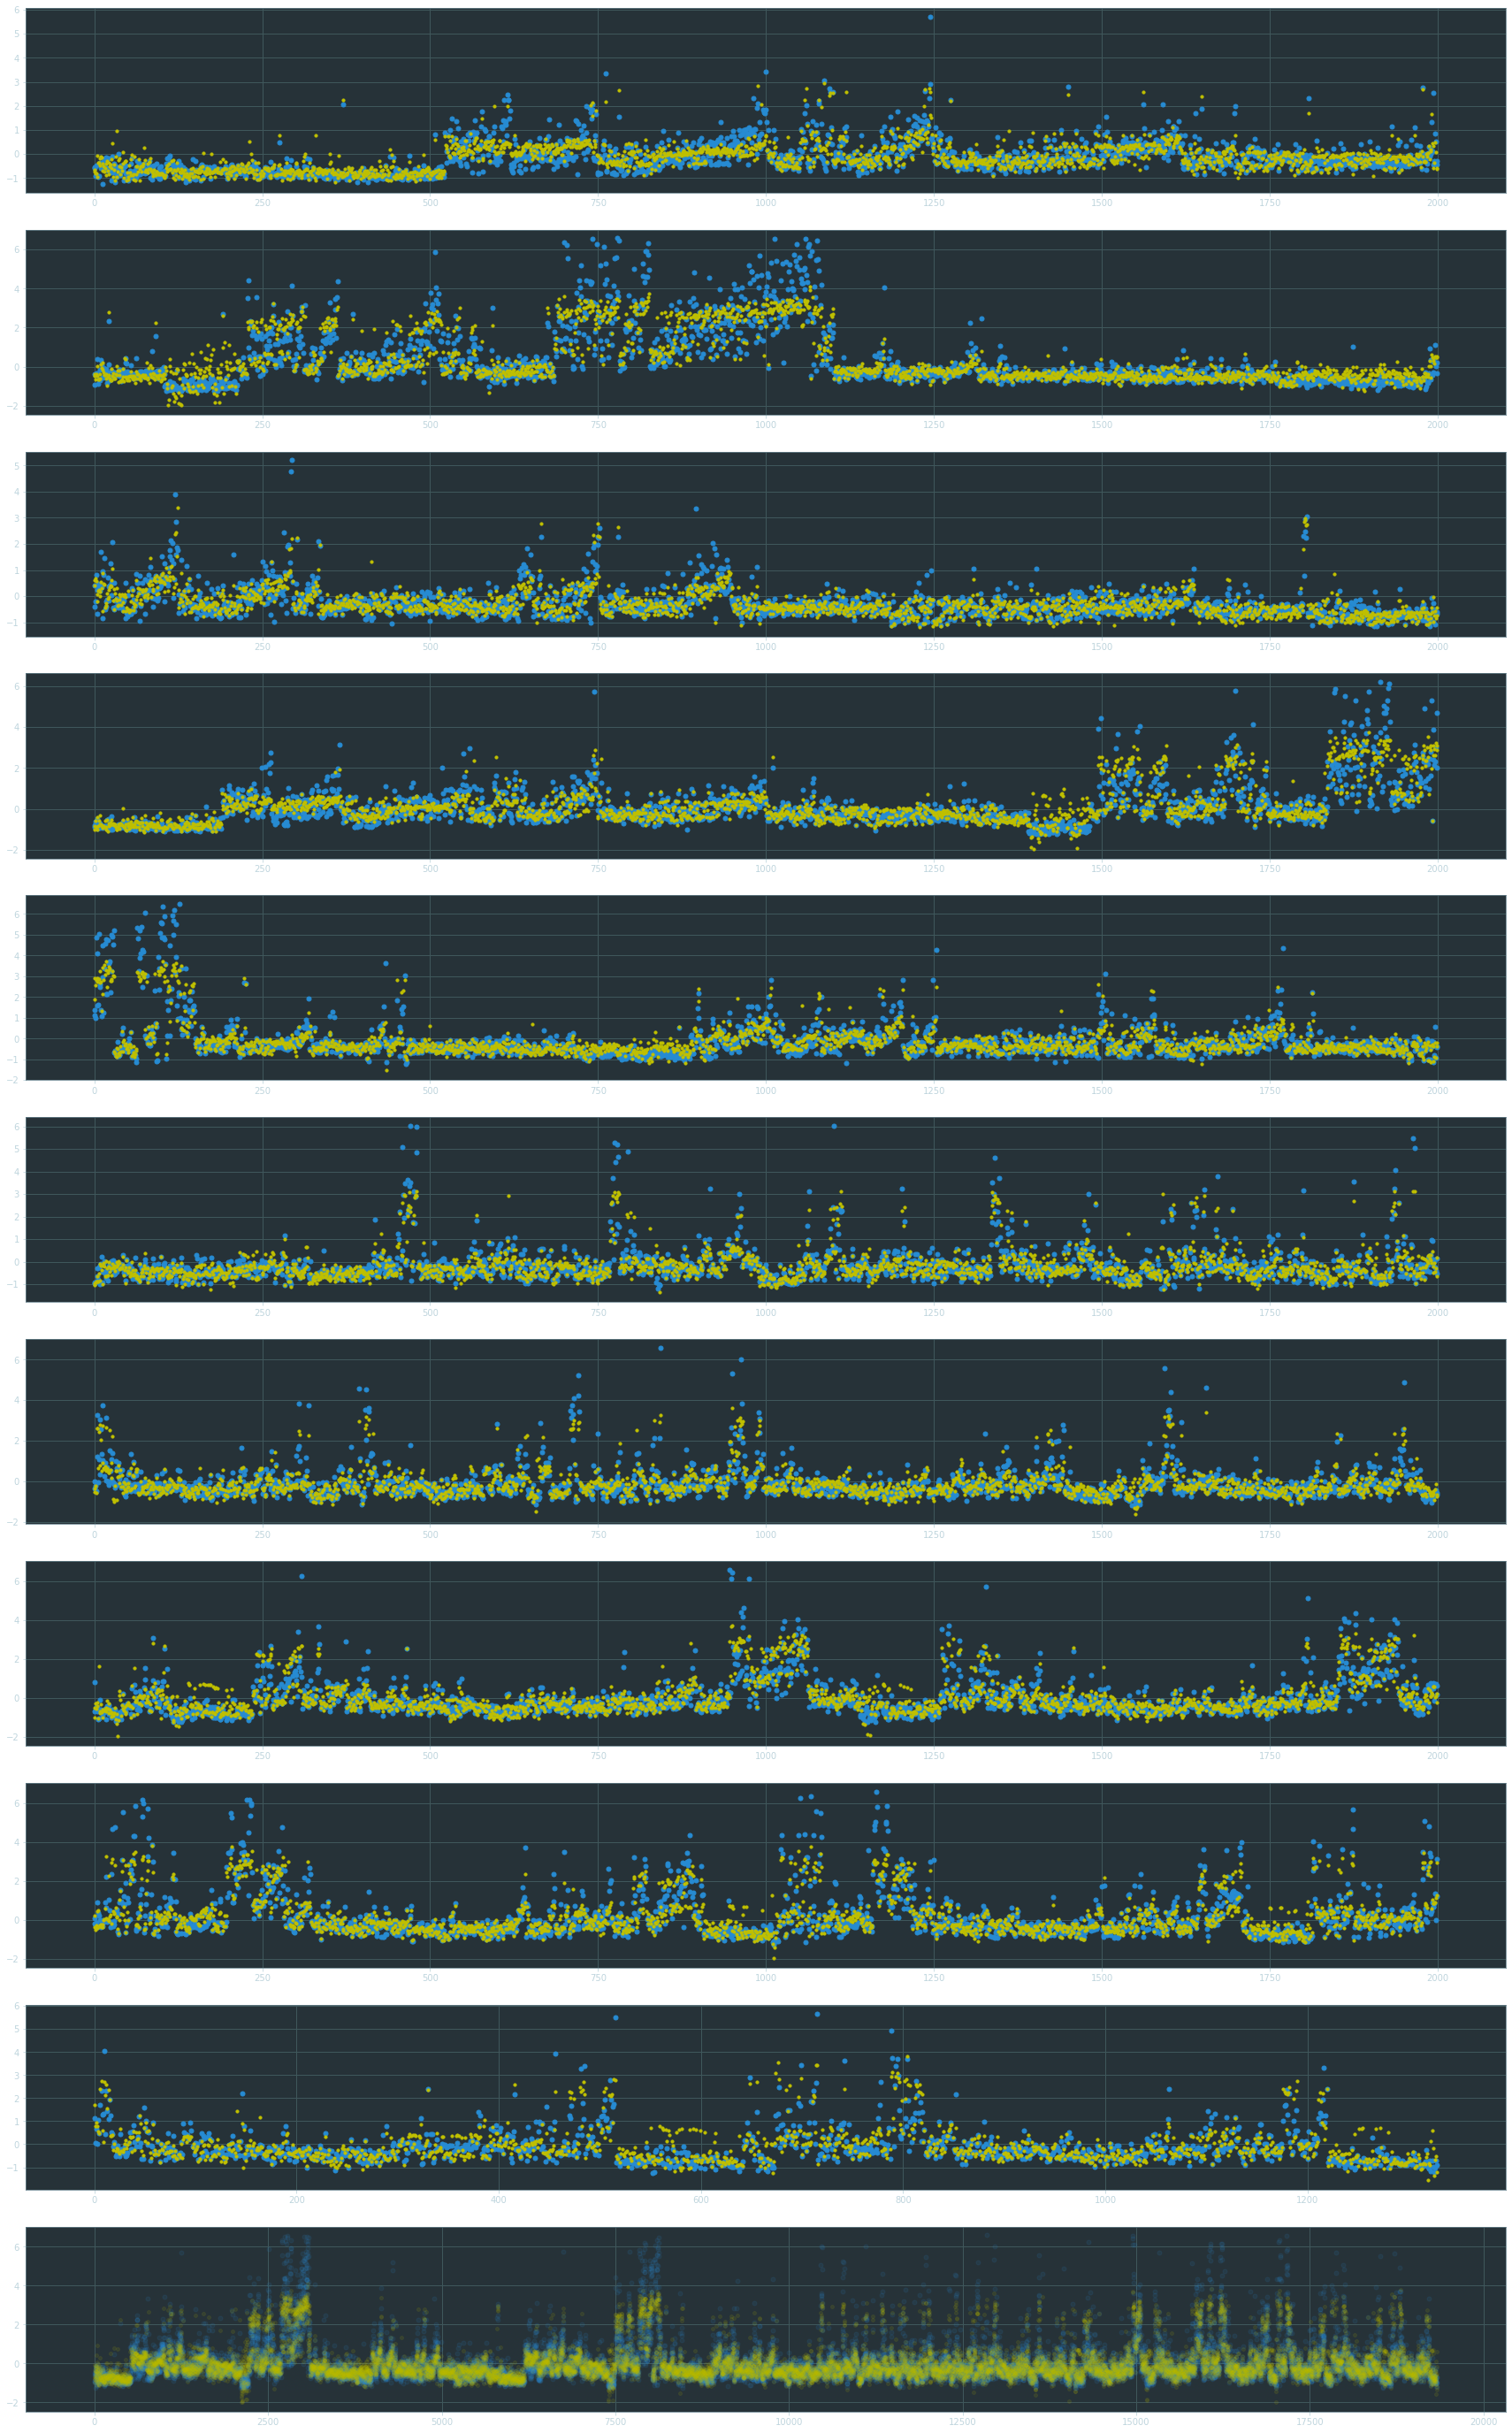

In [15]:
fig, plts = plt.subplots(nrows=11, ncols=1, figsize=(30, 50))

plts[10].scatter(range(len(y)), y, s=25, alpha=.1)
plts[10].scatter(range(len(y)), X.dot(w), s=15, c="y", alpha=.1)

plts[0].scatter(range(2000), y[:2000], s=25)
plts[0].scatter(range(2000), X.dot(w)[:2000], s=10, c="y")
plts[1].scatter(range(2000), y[2000:4000], s=25)
plts[1].scatter(range(2000), X.dot(w)[2000:4000], s=10, c="y")
plts[2].scatter(range(2000), y[4000:6000], s=25)
plts[2].scatter(range(2000), X.dot(w)[4000:6000], s=10, c="y")
plts[3].scatter(range(2000), y[6000:8000], s=25)
plts[3].scatter(range(2000), X.dot(w)[6000:8000], s=10, c="y")
plts[4].scatter(range(2000), y[8000:10000], s=25)
plts[4].scatter(range(2000), X.dot(w)[8000:10000], s=10, c="y")
plts[5].scatter(range(2000), y[10000:12000], s=25)
plts[5].scatter(range(2000), X.dot(w)[10000:12000], s=10, c="y")
plts[6].scatter(range(2000), y[12000:14000], s=25)
plts[6].scatter(range(2000), X.dot(w)[12000:14000], s=10, c="y")
plts[7].scatter(range(2000), y[14000:16000], s=25)
plts[7].scatter(range(2000), X.dot(w)[14000:16000], s=10, c="y")
plts[8].scatter(range(2000), y[16000:18000], s=25)
plts[8].scatter(range(2000), X.dot(w)[16000:18000], s=10, c="y")

plts[9].scatter(range(len(y[18000:])), y[18000:], s=25)
plts[9].scatter(range(len(y[18000:])), X.dot(w)[18000:], s=10, c="y");

In [16]:
# print(np.median(y), y.std())
plt.figure(figsize=(30, 10))
y_ = ((y-X.dot(w))**2)**.5
plt.scatter(range(len(y_)), y_, s=y_**3);

In [17]:
len(list(filter(lambda x: x>1, ((y-X.dot(w))**2)**.5)))

1063

In [18]:
np.mean(((y-X.dot(w))**2)**.5)

0.31394305879860135

In [19]:
plt.figure(figsize=(10, 10))
plt.scatter(y, X.dot(w), s=1);